<h1 align="center">Modeling</h1>

In [10]:
# Add project Root
import sys
from pathlib import Path

notebook_dir = Path().resolve()

PROJECT_ROOT = notebook_dir.parent

if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

print(f"Added to path: {PROJECT_ROOT}")

Added to path: C:\Data Science\Customer_Churn_Prediction


In [11]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import (
  classification_report,
  confusion_matrix,
  roc_auc_score,
  RocCurveDisplay
)

In [12]:
df=pd.read_excel('../data/raw/Telco_customer_churn.xlsx')

In [14]:
#Fix Data Types
df['Total Charges']=pd.to_numeric(df['Total Charges'],errors='coerce')
print(df['Total Charges'].dtype )

float64


In [15]:
y = df["Churn Value"]

X = df.drop(columns=[
    "Churn Value",
    "CustomerID",
    "Count",
    "Country",
    "State",
    "City",
    "Zip Code",
    "Lat Long",
    "Latitude",
    "Longitude",
    "Churn Label",
    "Churn Reason",
    "Churn Score",
    "CLTV"
])


In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [17]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

num_features = [
    "Tenure Months",
    "Monthly Charges",
    "Total Charges"
]

cat_features = [col for col in X.columns if col not in num_features]

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)
])


In [18]:
#logistic regression
log_reg_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("log_reg", LogisticRegression(
      max_iter=1000,
      class_weight="balanced",
        random_state=42))
])
# Train the Pipeline
log_reg_pipeline.fit(X_train, y_train)

# Evaluate Normally
y_pred = log_reg_pipeline.predict(X_test)
y_prob = log_reg_pipeline.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1035
           1       0.51      0.78      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.76      1409



In [19]:
roc_auc_score(y_test, y_prob)


np.float64(0.8487561032318065)

In [20]:
cm=confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, 
                     index=['Actual Stay (0)', 'Actual Churn (1)'], 
                     columns=['Predicted Stay (0)', 'Predicted Churn (1)'])

print("Confusion Matrix:")
print(cm_df)

Confusion Matrix:
                  Predicted Stay (0)  Predicted Churn (1)
Actual Stay (0)                  755                  280
Actual Churn (1)                  82                  292


In [21]:
#random forest
rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("rf", RandomForestClassifier(
      n_estimators=200,
      class_weight="balanced",
      random_state=42))
])
# Train the Pipeline
rf_pipeline.fit(X_train, y_train)
# Evaluate Normally
y_pred_rf = rf_pipeline.predict(X_test)
y_prob_rf = rf_pipeline.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred_rf))
roc_auc_score(y_test, y_prob_rf)

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.63      0.49      0.55       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409



np.float64(0.8319008499315405)

In [22]:
#xgboost
xgb_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("xgb", xgb.XGBClassifier(
      n_estimators=200,
      class_weight="balanced",
      random_state=42))
])
# Train the Pipeline
xgb_pipeline.fit(X_train, y_train)
# Evaluate Normally
y_pred_xgb = xgb_pipeline.predict(X_test)
y_prob_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred_xgb))
roc_auc_score(y_test, y_prob_xgb)

c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [06:20:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.84      0.87      0.85      1035
           1       0.60      0.54      0.57       374

    accuracy                           0.78      1409
   macro avg       0.72      0.70      0.71      1409
weighted avg       0.78      0.78      0.78      1409



np.float64(0.8273334366684749)

In [23]:
#Compare Models 
results = pd.DataFrame({
    "Model": [
        "Logistic Regression",
        "Random Forest",
        "XGBoost"
    ],
    "ROC AUC Score": [
        roc_auc_score(y_test, y_prob),
        roc_auc_score(y_test, y_prob_rf),
        roc_auc_score(y_test, y_prob_xgb)
    ]
})
results

,Model,ROC AUC Score
0,Logistic Regression,0.848756
1,Random Forest,0.831901
2,XGBoost,0.827333


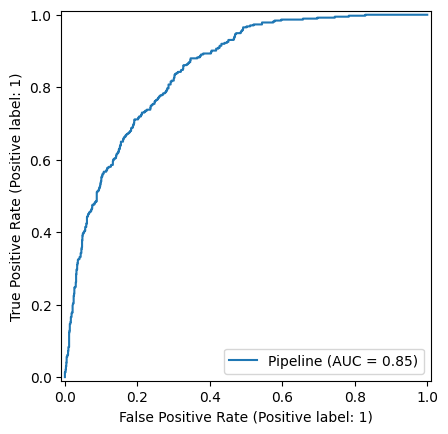

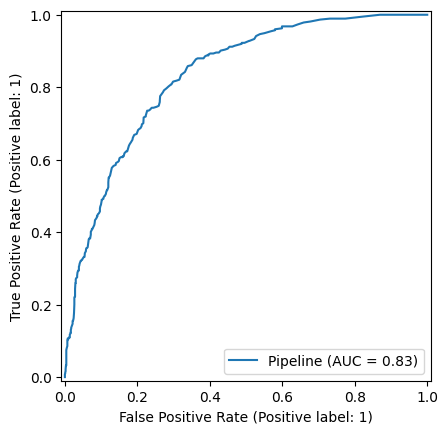

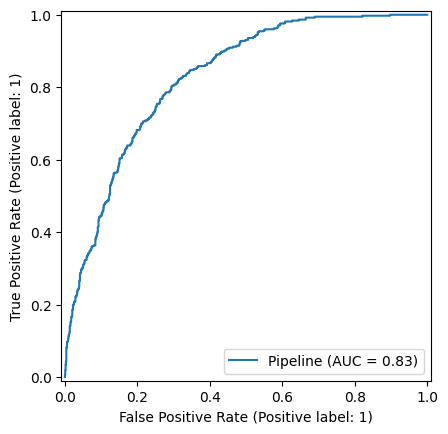

In [24]:
#ROC Curve [Professinal Touch]

RocCurveDisplay.from_estimator(log_reg_pipeline, X_test, y_test)
RocCurveDisplay.from_estimator(rf_pipeline, X_test, y_test)
RocCurveDisplay.from_estimator(xgb_pipeline, X_test, y_test)

plt.show()

## Modeling & Results

Three supervised learning models were trained and evaluated to predict customer churn. All models were trained using a unified preprocessing pipeline to ensure consistent feature handling and to prevent data leakage.

### Models Evaluated
- Logistic Regression (baseline model)
- Random Forest Classifier
- XGBoost Classifier

### Evaluation Metric
Due to class imbalance and the business importance of identifying churned customers, the **ROC-AUC score** was selected as the primary evaluation metric. ROC-AUC provides a robust measure of a model’s ability to distinguish between churned and non-churned customers across different classification thresholds.

### Model Performance

| Model                | ROC-AUC |
|---------------------|---------|
| Logistic Regression | 0.84    |
| Random Forest       | 0.83    |
| XGBoost             | 0.82    |

### Key Observations
- Logistic Regression achieved the highest ROC-AUC score, indicating strong predictive performance despite its simplicity.
- Tree-based models (Random Forest and XGBoost) performed competitively but did not outperform the linear baseline in this dataset.
- The strong performance of Logistic Regression suggests that churn behavior in this dataset is largely driven by linear relationships between features and the target variable.

### Model Selection
Based on performance, interpretability, and stability, **Logistic Regression** was selected as the candidate model for further evaluation and threshold optimization. Its simplicity and explainability also make it more suitable for business decision-making and stakeholder communication.
